In [1]:
import numpy as np
import grid2op
from grid2op.PlotGrid import PlotMatplot
from lightsim2grid import LightSimBackend
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import copy
import pandas as pd
import plotly.express as px 
# import plotly.graph_objs as go

from l2rpn_baselines.DuelQSimple import evaluate
import shutil
from tqdm import tqdm
from grid2op.Runner import Runner
from grid2op.Episode import EpisodeData
from grid2op.Reward import GameplayReward
from grid2op.Parameters import Parameters
from l2rpn_baselines.OptimCVXPY import OptimCVXPY

2023-03-07 16:18:40.621487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-07 16:18:40.621510: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Preprocessing

In [2]:
env = grid2op.make("educ_case14_storage_custom",
                    backend=LightSimBackend(),
                    reward_class = GameplayReward,
                    )
param = env.parameters
param.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = True
# param.INIT_STORAGE_CAPACITY = 0.0
env.change_parameters(param)
env.reset()

In [3]:
from run_trained_agents import get_agent

path_agents = "./saved_model/expe_case_14/expe_hp/"
# path_agents = "./saved_model/expe_case_14/expe_to_run/"
# machine_dir = "GymEnvWithRecoDNShuffle14_rewgp_bs2"
# machine_dir = "GymEnvWithRecoDNShuffle14_stor_only"
# machine_dir = "GymEnvWithRecoDNShuffle14_stor_only_bs"
# machine_dir = "case14_stor_only_bs256_50M"
# machine_dir = "case14_stor_rand_5M"
machine_dir = "case14_stor_only_7s_5M"
# machine_dir = "case14_stor_only_lr_20M"
# machine_dir = "case14_stor_only_lr_20M_d3_20230124_161428_learning_rate_1"
root_dir = os.path.abspath(path_agents)
submission_dir  = os.path.join(root_dir, machine_dir)
list_names = [name for name in os.listdir(submission_dir) if name.endswith("2")]
name = list_names[0]
print("name:", name)

training_iter = 5_000_000

agent_dir = os.path.join(submission_dir, name)
weights_dir = os.path.join(agent_dir, f"{name}_{training_iter}_steps.zip")

# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_stor_only_lr_20M_d2_20230124_161312_learning_rate_1/case14_stor_only_lr_20M_d2_20230124_161312_learning_rate_1.zip"
# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_stor_only_lr_20M_d1_20230124_161356_learning_rate_1/case14_stor_only_lr_20M_d1_20230124_161356_learning_rate_1.zip"
# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_stor_only_lr_20M_d3_20230124_161428_learning_rate_1/case14_stor_only_lr_20M_d3_20230124_161428_learning_rate_1_15500000_steps.zip"

# weights_dir = "/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/saved_model/expe_case_14/expe_to_run/case14_stor_only_7s_5M_20230127_150418_learning_rate_0/case14_stor_only_7s_5M_20230127_150418_learning_rate_0_2750000_steps.zip"

agent = get_agent( # submission_dir,
                                # agent_dir,
                                weights_dir,
                                env,
                                0.2,
                                -1)


# name = "OptimCVXPY"
# agent = OptimCVXPY(env.action_space,
#                    env,
#                    penalty_redispatching_unsafe=100,
#                    penalty_redispatching_safe=100,
#                    penalty_storage_unsafe=100, # 0.01,
#                    penalty_storage_safe=100, # 0.01,
#                    penalty_curtailment_unsafe=0.001,
#                    penalty_curtailment_safe=0.001, # Not initially there
#                    rho_safe=0.2,
#                    rho_danger=0.8,
#                    margin_th_limit=0.93,
#                    alpha_por_error=0.5,
#                    weight_redisp_target=0.3)

agent

name: case14_stor_only_7s_5M_20230130_151721_learning_rate_2
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [67]:
save_path = "./model_results/"
path_save_results = os.path.join(save_path, name)
shutil.rmtree(path_save_results, ignore_errors=True)

In [68]:
param = env.parameters
param.INIT_STORAGE_CAPACITY = 0.
env.change_parameters(param)
env.reset()

NB_EPISODE = len(env.chronics_handler.real_data.available_chronics())
MAX_ITER = env.max_episode_duration()

try:
    all_episodes = EpisodeData.list_episode(path_save_results)
except FileNotFoundError:
    test_runner = Runner(**env.get_params_for_runner(),
                        agentInstance=agent, agentClass=None)
    res = test_runner.run(nb_episode=NB_EPISODE,
                        max_iter=MAX_ITER,
                        pbar=tqdm,
                        path_save=path_save_results
                        )
    all_episodes = EpisodeData.list_episode(path_save_results)

all_episodes


episode: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


[('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/case14_stor_only_7s_5M_20230130_151721_learning_rate_2',
  '2019-01-12'),
 ('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/case14_stor_only_7s_5M_20230130_151721_learning_rate_2',
  '2019-01-13'),
 ('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/case14_stor_only_7s_5M_20230130_151721_learning_rate_2',
  '2019-01-14'),
 ('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/case14_stor_only_7s_5M_20230130_151721_learning_rate_2',
  '2019-01-15'),
 ('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/case14_stor_only_7s_5M_20230130_151721_learning_rate_2',
  '2019-01-16'),
 ('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/case14_stor_only_7s_5M_20230130_151721_learning_rate_2',
  '2019-01-17'),
 ('/home/boguslawskieva/L2RPN-WCCI-Baselines/RL/model_results/case14_stor_only_7s_5M_20230130_151721_learning_rate_2',
  '2019-01-18')]

In [45]:
# NB_EPISODE = len(env.chronics_handler.real_data.available_chronics())
# MAX_ITER = env.max_episode_duration()


# test_runner = Runner(**env.get_params_for_runner(),
#                     agentInstance=agent, agentClass=None)
# res = test_runner.run(nb_episode=NB_EPISODE,
#                     max_iter=MAX_ITER,
#                     pbar=tqdm,
#                     )


episode: 288it [00:00, 328.28it/s]00<?, ?it/s]
episode: 288it [00:00, 326.27it/s]01<00:06,  1.15s/it]
episode: 229it [00:00, 327.37it/s]02<00:05,  1.17s/it]
episode: 288it [00:01, 273.48it/s]03<00:04,  1.08s/it]
episode: 234it [00:00, 326.13it/s]04<00:03,  1.17s/it]
episode: 288it [00:00, 350.25it/s]05<00:02,  1.11s/it]
episode: 288it [00:00, 331.50it/s]06<00:01,  1.11s/it]
episode: 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Résultats DN : 288, 288, 220, 90, 236, 234, 86

# Study actions

In [56]:
episode_list = [EpisodeData.from_disk(*all_episodes[i]) for i in range(7)]
episode_act_array = [np.array([[*act._storage_power, *act._curtail[2:5]] for act in this_episode.actions]) for this_episode in episode_list]

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



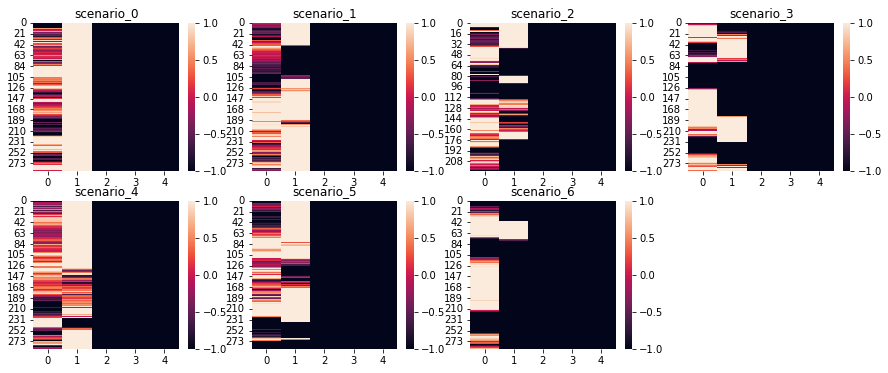

In [7]:
plt.figure(figsize=(15, 6))
for i in range(7):
    plt.subplot(2,4,i+1)
    sns.heatmap(episode_act_array[i], vmin=-1, vmax=1)
    plt.title(f"scenario_{i}")
plt.show()

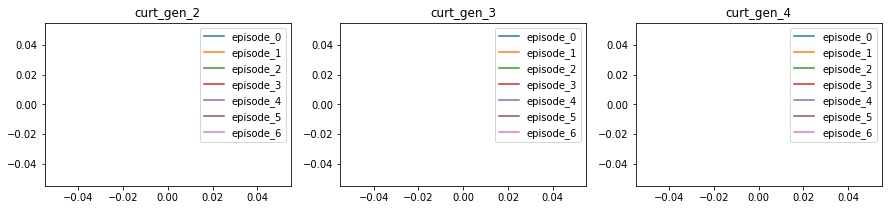

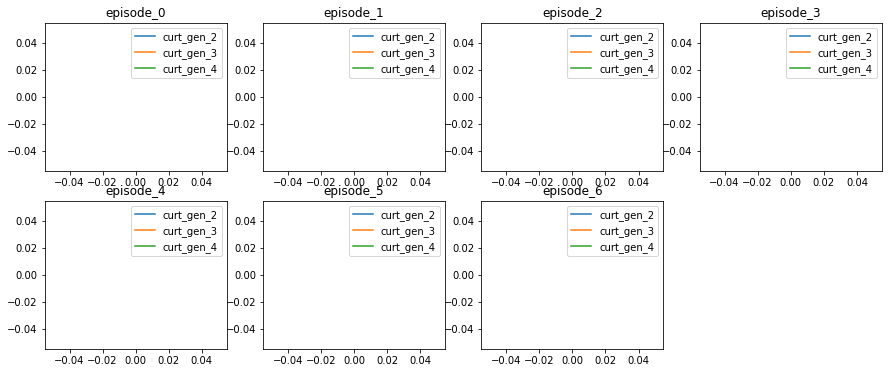

In [47]:
label = ["storage_0", "storage_1", "curt_gen_2", "curt_gen_3", "curt_gen_4"]
plt.figure(figsize=(15,3))
for i in range(2,5):
    plt.subplot(1,3,i-1)
    for j in range(7):
        y = copy.deepcopy(episode_act_array[j][:,i])
        y[y==-1] = np.nan
        plt.plot(y, label = f"episode_{j}")
    plt.title(label[i])
    plt.legend()
plt.show()

label = ["storage_0", "storage_1", "curt_gen_2", "curt_gen_3", "curt_gen_4"]
plt.figure(figsize=(15,6))
for j in range(7):
    plt.subplot(2,4,j+1)
    for i in range(2,5):
        y = copy.deepcopy(episode_act_array[j][:,i])
        y[y==-1] = np.nan
        plt.plot(y, label = label[i])
    plt.title(f"episode_{j}")
    plt.legend()
plt.show()


In [57]:
label = ["storage_0", "storage_1", "curt_gen_2", "curt_gen_3", "curt_gen_4"]
data = pd.concat([pd.DataFrame(episode, columns=label).assign(scenario_id = i).reset_index() for i, episode in enumerate(episode_act_array)], axis="index", ignore_index=True) \
    .astype({'scenario_id': 'str'}) \
    .rename(columns={"index":"timestep"})
data[data==-1] = np.nan

data_melt = pd.melt(data, id_vars=['timestep', 'scenario_id'], value_vars=["storage_0", "storage_1", "curt_gen_2", "curt_gen_3", "curt_gen_4"], 
            var_name ="action_name", value_name="action_value")
data_melt.head(5)

timestep scenario_id action_name  action_value
0         0           0   storage_0      1.855650
1         1           0   storage_0      2.588826
2         2           0   storage_0      0.888658
3         3           0   storage_0      1.659396
4         4           0   storage_0      1.870394

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


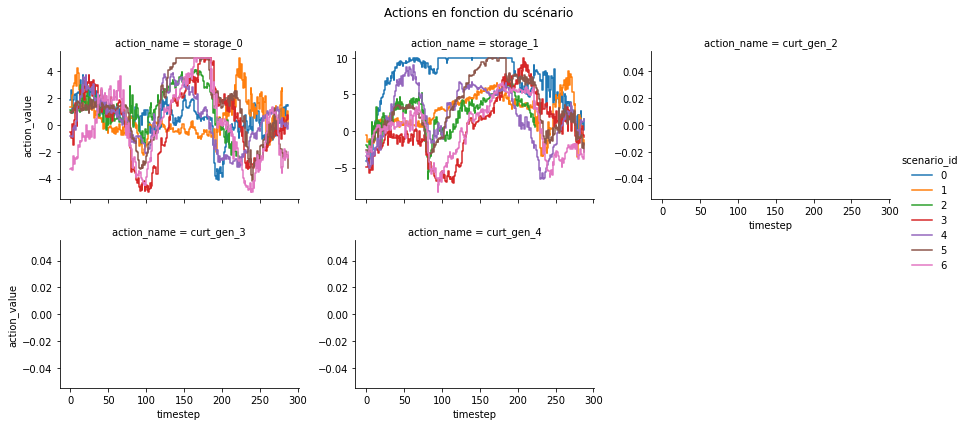

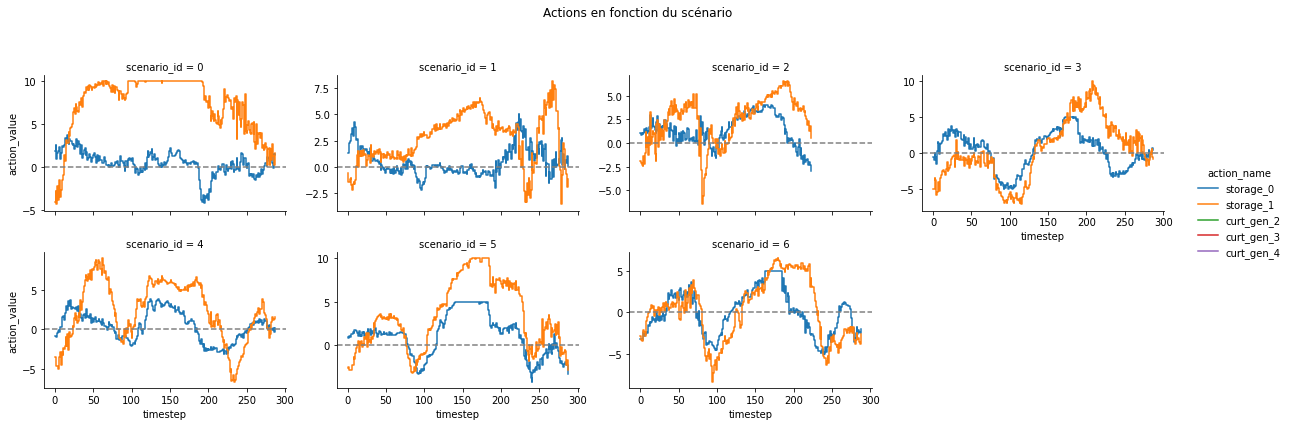

In [12]:
g = sns.relplot(data=data_melt, x = "timestep", y = "action_value", hue="scenario_id", col="action_name", drawstyle='steps-post',
        kind="line", col_wrap=3, facet_kws={'sharey': False}, height=2.8, aspect=1.5) \
        .fig.suptitle('Actions en fonction du scénario', y=1.05)

g = sns.relplot(data=data_melt, x = "timestep", y = "action_value", hue="action_name", col="scenario_id", drawstyle='steps-post',
    kind="line", col_wrap=4, facet_kws={'sharey': False}, height=2.8, aspect=1.5)
g.fig.suptitle('Actions en fonction du scénario', y=1.05)
g.refline(y=0, ls = "--", color="grey")

# Study observations

In [58]:
episode_list = [EpisodeData.from_disk(*all_episodes[i]) for i in range(7)]

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [59]:
df_storage = pd.concat([pd.DataFrame({"scenario_id":j, "timestep":i, "storage_id":np.arange(obs.n_storage), 
                                "storage_charge":obs.storage_charge, "storage_power":obs.storage_power,
                                "storage_power_target":obs.storage_power_target}) 
                    for j in range(len(episode_list))
                    for i, obs in enumerate(episode_list[j].observations)],
                    ignore_index=True) \
                .astype({'scenario_id': 'str', 'storage_id':'str'})

df_storage.head(5)

scenario_id  timestep storage_id  storage_charge  storage_power  \
0           0         0          0        0.000000       0.000000   
1           0         0          1        0.000000       0.000000   
2           0         1          0        0.138572       1.855650   
3           0         1          1        0.000000       0.000000   
4           0         2          0        0.335188       2.588826   

   storage_power_target  
0              0.000000  
1              0.000000  
2              1.855650  
3             -4.045849  
4              2.588826

In [60]:
# df_storage = df_storage[df_storage["scenario_id"]=="6"]
g = px.line(df_storage, x = "timestep", y = ["storage_power", "storage_power_target"], facet_row="scenario_id", 
    facet_col="storage_id", height=1000
    )
g.add_hline(y=0, line_width=2, line_dash="dash", line_color="grey")
g.show()

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [25]:
env.action_space.storage_max_p_absorb, env.action_space.storage_max_p_prod

(array([ 5., 10.], dtype=float32), array([ 5., 10.], dtype=float32))

In [36]:
df_storage.timestep.max()

288

In [30]:
df = df_storage.copy()
df_temp = df.groupby(["scenario_id"])[["timestep"]].agg("max").reset_index().rename({"timestep":"ts_survived"}, axis=1)
df = pd.merge(df, df_temp, how='left', on=['scenario_id'])
df = df[df.timestep != df.ts_survived]
df


/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



scenario_id  timestep storage_id  storage_charge  storage_power  \
0              0         0          0        0.000000       0.000000   
1              0         0          1        0.000000       0.000000   
2              0         1          0        0.387500       5.000000   
3              0         1          1        0.000000       0.000000   
4              0         2          0        0.775000       5.000000   
...          ...       ...        ...             ...            ...   
3347           6       285          1        6.991667       0.099998   
3348           6       286          0        5.688828      -0.811130   
3349           6       286          1        6.991667       0.099998   
3350           6       287          0        5.561753      -1.424891   
3351           6       287          1        6.991667       0.100001   

      storage_power_target  ts_survived  
0                 0.000000          288  
1                 0.000000          288  
2                 5.000000          288  
3               -10.000000          288  
4                 5.000000          288  
...                    ...          ...  
3347              9.508432          288  
3348             -0.811130          288  
3349              9.559319          288  
3350             -1.424891          288  
3351              9.484969          288  

[3340 rows x 7 columns]

In [31]:
df = df_storage.copy()
df_temp = df.groupby(["scenario_id"])[["timestep"]].agg("max").reset_index().rename({"timestep":"ts_survived"}, axis=1)
df = pd.merge(df, df_temp, how='left', on=['scenario_id'])
df = df[df.timestep != df.ts_survived]

g = px.line(df, x = "timestep", y = "storage_charge", facet_col="scenario_id", 
    color="storage_id", facet_col_wrap=4
    )
g.add_hline(y=0, line_width=2, line_dash="dash", line_color="grey")
g.add_hline(y=7, line_width=2, line_dash="dash", line_color="grey")
g.add_hline(y=15, line_width=2, line_dash="dash", line_color="grey")
g.show()

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [22]:
df_gen = pd.concat([pd.DataFrame({"scenario_id":j, "timestep":i, "gen_id":np.arange(obs.n_gen), 
                                "is_renewable":env.gen_renewable, "gen_p":obs.gen_p, "curtailment_mw":obs.curtailment_mw, 
                                "curtailment": obs.curtailment, "gen_p_before_curtail": obs.gen_p_before_curtail,
                                "curtailment_limit_mw": obs.curtailment_limit * obs.gen_pmax}) 
                    for j in range(len(episode_list))
                    for i, obs in enumerate(episode_list[j].observations)],
                    ignore_index=True) \
                .astype({'scenario_id': 'str', 'gen_id':'str'})

df_temp = df_gen.groupby(["scenario_id", "timestep"]).agg("sum").reset_index() \
                .assign(is_renewable = None, gen_id = "total")

df_gen = pd.concat([df_gen, df_temp], ignore_index=True)
df_gen.head(5)

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



scenario_id  timestep gen_id is_renewable      gen_p  curtailment_mw  \
0           0         0      0        False  83.400002             0.0   
1           0         0      1        False  81.900002             0.0   
2           0         0      2         True  17.299999             0.0   
3           0         0      3         True   0.000000             0.0   
4           0         0      4         True   0.000000             0.0   

   curtailment  gen_p_before_curtail  curtailment_limit_mw  
0          0.0              0.000000                 140.0  
1          0.0              0.000000                 120.0  
2          0.0             17.299999                  70.0  
3          0.0              0.000000                  70.0  
4          0.0              0.000000                  40.0

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



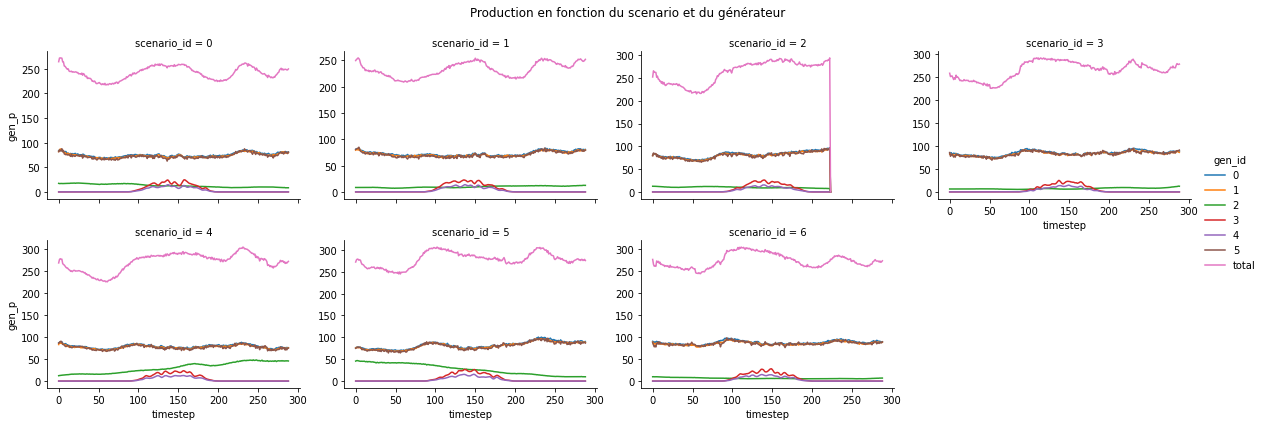

In [23]:
g = sns.relplot(data=df_gen, x = "timestep", y = "gen_p", hue="gen_id", col="scenario_id",
        kind="line", col_wrap=4, facet_kws={'sharey': False}, height=2.8, aspect=1.5) \
        .fig.suptitle('Production en fonction du scenario et du générateur', y=1.05)

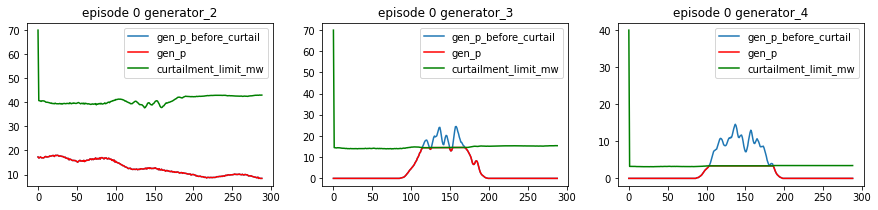

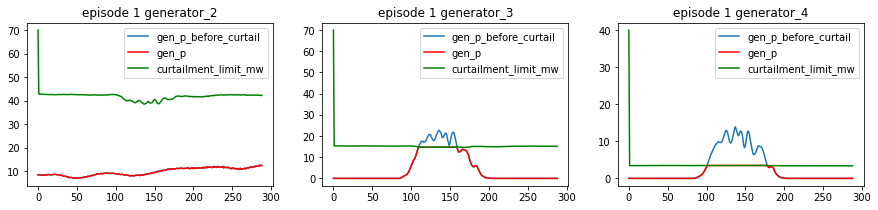

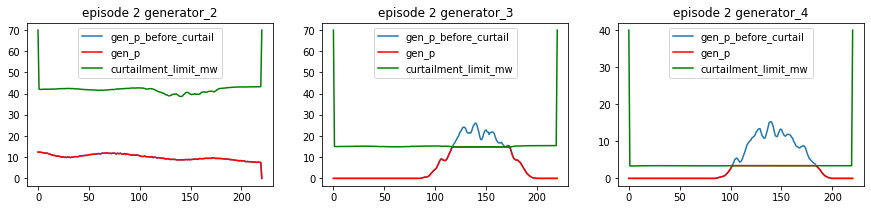

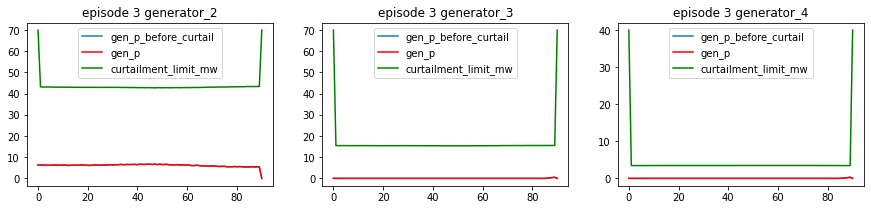

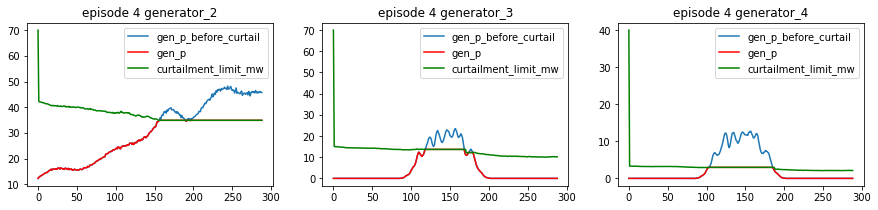

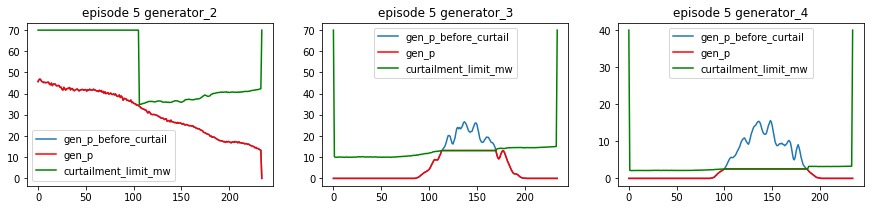

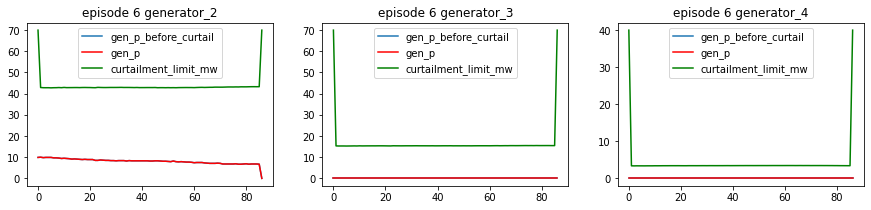

In [23]:
for episode_id in range(7):
    plt.figure(figsize=(15,3))
    for id_gen in range(2,5):
        plt.subplot(1,3,id_gen-1)
        df = df_gen[np.logical_and(df_gen["scenario_id"]==str(episode_id), df_gen["gen_id"]==str(id_gen))].reset_index()
        plt.plot(df["gen_p_before_curtail"], label = "gen_p_before_curtail")
        plt.plot(df['gen_p'], color="red", label = "gen_p")
        plt.plot(df['curtailment_limit_mw'], color="green", label = "curtailment_limit_mw")
        plt.title(f'episode {episode_id} generator_{id_gen}')
        plt.legend()
    plt.show()

## Production by generators by scenario

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



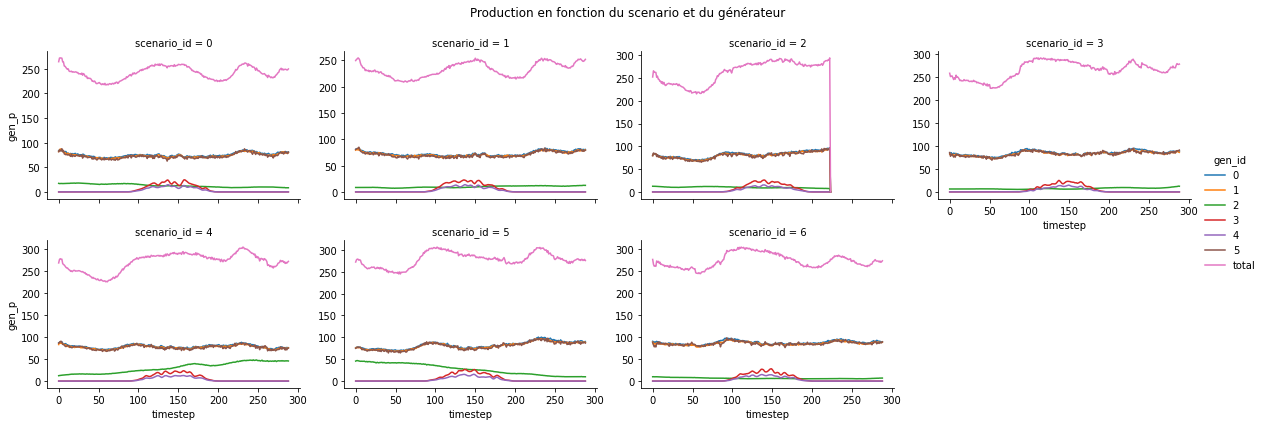

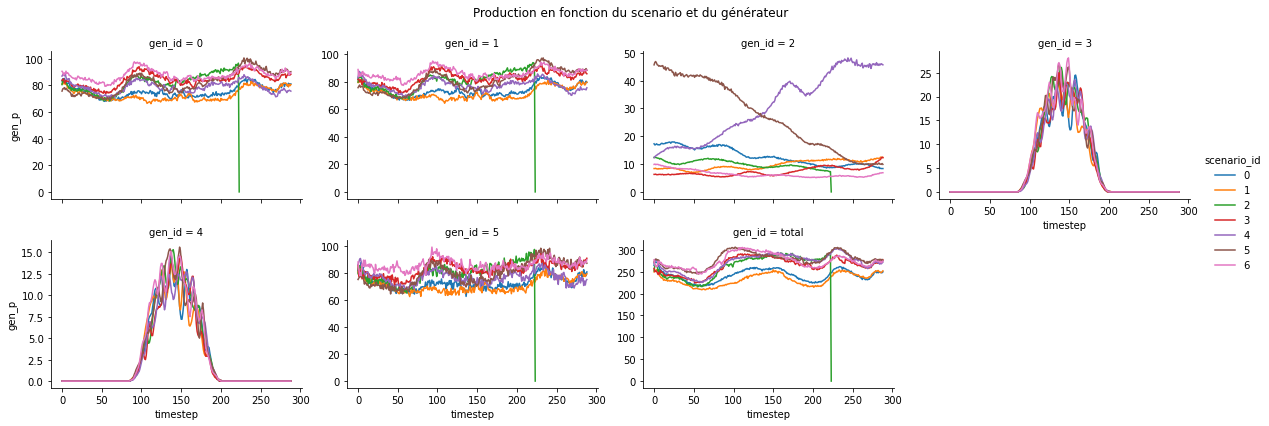

In [24]:
g = sns.relplot(data=df_gen, x = "timestep", y = "gen_p", hue="gen_id", col="scenario_id",
        kind="line", col_wrap=4, facet_kws={'sharey': False}, height=2.8, aspect=1.5) \
        .fig.suptitle('Production en fonction du scenario et du générateur', y=1.05)

g = sns.relplot(data=df_gen, x = "timestep", y = "gen_p", hue="scenario_id", col="gen_id",
        kind="line", col_wrap=4, facet_kws={'sharey': False}, height=2.8, aspect=1.5) \
        .fig.suptitle('Production en fonction du scenario et du générateur', y=1.05)

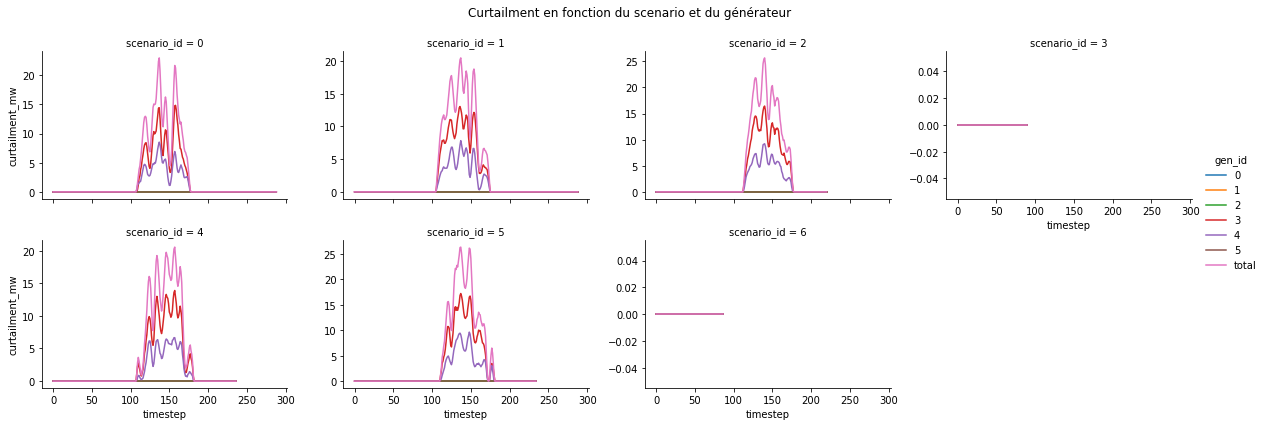

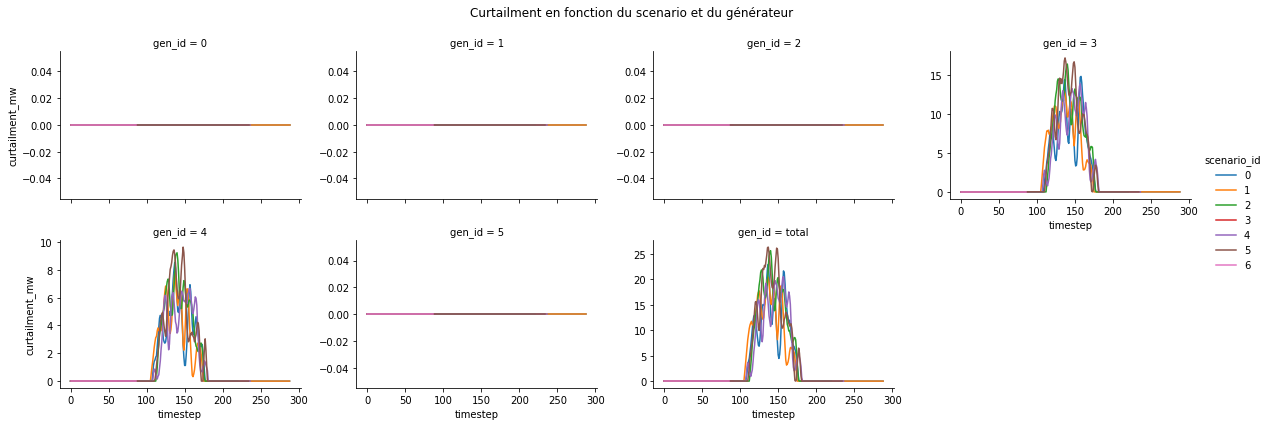

In [16]:
g = sns.relplot(data=df_gen, x = "timestep", y = "curtailment_mw", hue="gen_id", col="scenario_id",
        kind="line", col_wrap=4, facet_kws={'sharey': False}, height=2.8, aspect=1.5) \
        .fig.suptitle('Curtailment en fonction du scenario et du générateur', y=1.05)

g = sns.relplot(data=df_gen, x = "timestep", y = "curtailment_mw", hue="scenario_id", col="gen_id",
        kind="line", col_wrap=4, facet_kws={'sharey': False}, height=2.8, aspect=1.5) \
        .fig.suptitle('Curtailment en fonction du scenario et du générateur', y=1.05)

In [150]:
g = px.line(df_gen, x = "timestep", y = "curtailment_mw", facet_col="scenario_id", color="gen_id",
    facet_col_wrap=4, title="Curtailment mw par scénario par gen")
# g.add_hline(y=1, line_width=2, line_dash="dash", line_color="grey")
g.show()

In [151]:
g = px.line(df_gen, x = "timestep", y = "curtailment", facet_col="scenario_id", color="gen_id",
    facet_col_wrap=4, title="Curtailment par scénario par gen")
# g.add_hline(y=1, line_width=2, line_dash="dash", line_color="grey")
g.show()

In [77]:
env.gen_type

array(['nuclear', 'thermal', 'wind', 'solar', 'solar', 'hydro'],
      dtype='<U10')

## Consumption by scenario by load

In [25]:
df_load = pd.concat([pd.DataFrame({"scenario_id":j, "timestep":i, "load_id":np.arange(obs.n_load), "load_p":obs.load_p}) 
                    for j in range(len(episode_list))
                    for i, obs in enumerate(episode_list[j].observations)],
                    ignore_index=True) \
                .astype({'scenario_id': 'str', 'load_id':'str'})

df_temp = df_load.groupby(["scenario_id", "timestep"]).agg("sum").reset_index() \
                .assign(load_id = "total")

df_load = pd.concat([df_load, df_temp], ignore_index=True)
df_load.head(5)

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



scenario_id  timestep load_id     load_p
0           0         0       0  22.000000
1           0         0       1  90.599998
2           0         0       2  50.700001
3           0         0       3   7.600000
4           0         0       4  11.400000

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



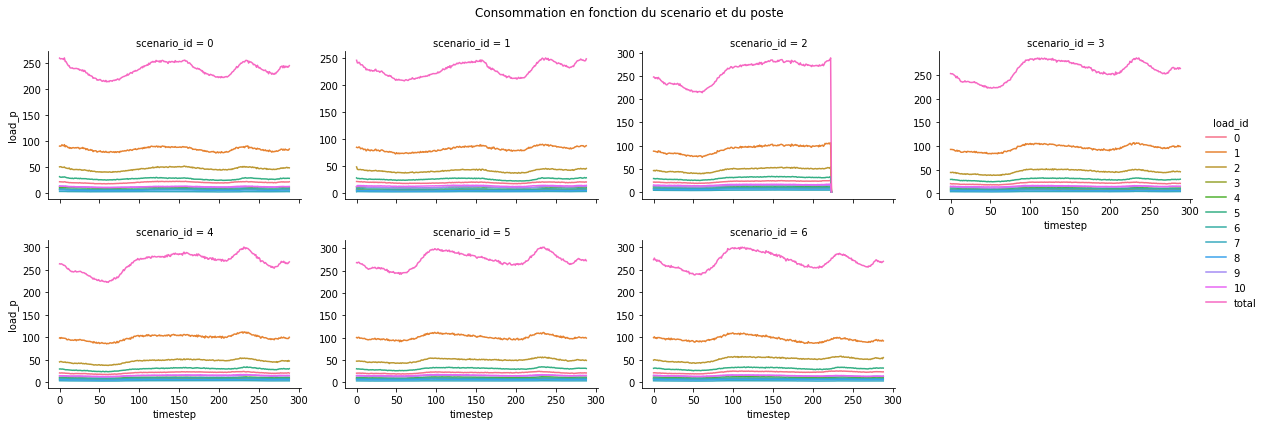

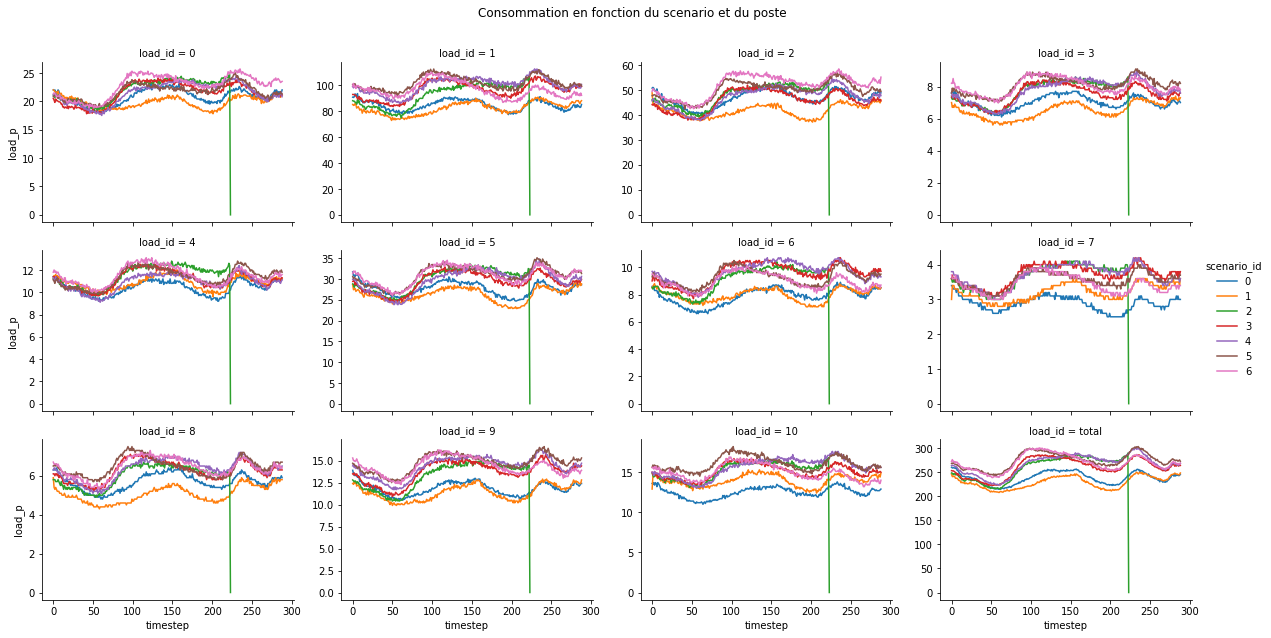

In [26]:
g = sns.relplot(data=df_load, x = "timestep", y = "load_p", hue="load_id", col="scenario_id",
        kind="line", col_wrap=4, facet_kws={'sharey': False}, height=2.8, aspect=1.5) \
        .fig.suptitle('Consommation en fonction du scenario et du poste', y=1.05)

g = sns.relplot(data=df_load, x = "timestep", y = "load_p", hue="scenario_id", col="load_id",
        kind="line", col_wrap=4, facet_kws={'sharey': False}, height=2.8, aspect=1.5) \
        .fig.suptitle('Consommation en fonction du scenario et du poste', y=1.05)

## Capacity by line by scenario

In [27]:
df_line = pd.concat([pd.DataFrame({"scenario_id":j, "timestep":i, "line_id":np.arange(obs.n_line), "rho":obs.rho}) 
                    for j in range(len(episode_list))
                    for i, obs in enumerate(episode_list[j].observations)],
                    ignore_index=True) \
                .astype({'scenario_id': 'str', 'line_id':'str'})
df_line.head(5)

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



scenario_id  timestep line_id       rho
0           0         0       0  0.338955
1           0         0       1  0.356180
2           0         0       2  0.288605
3           0         0       3  0.271821
4           0         0       4  0.817844

In [28]:
g = px.line(df_line, x = "timestep", y = "rho", facet_col="scenario_id", color="line_id",
    facet_col_wrap=4, title="Capacité des lignes par scénario")
g.add_hline(y=1, line_width=2, line_dash="dash", line_color="grey")
g.show()

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



# Why is there -1 for curtailment and 0 for batteries ?

In [42]:
this_episode = EpisodeData.from_disk(*all_episodes[0])

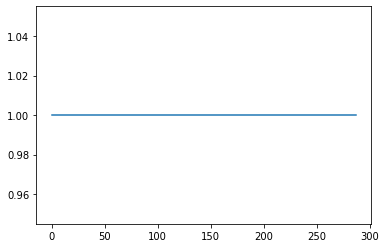

In [214]:
plt.plot(this_episode.rewards)

In [49]:
obs = this_episode.observations[150]
rew = this_episode.rewards[150]
done = False
act = agent.act(obs, rew, done)
act._storage_power, act._curtail

(array([0., 0.], dtype=float32),
 array([-1.        , -1.        ,  0.57751083,  0.20832126, -1.        ,
        -1.        ], dtype=float32))

In [44]:
obs = this_episode.observations[151]
obs.curtailment, obs.curtailment_limit, obs.curtailment_limit_effective, obs.storage_power

(array([0.     , 0.     , 0.     , 0.     , 0.09546, 0.     ],
       dtype=float32),
 array([1.        , 1.        , 0.57751083, 0.20832126, 0.08453999,
        1.        ], dtype=float32),
 array([1.        , 1.        , 0.57751083, 0.20832126, 0.08453999,
        1.        ], dtype=float32),
 array([0., 0.], dtype=float32))

In [56]:
act = agent.l2rpn_agent.act(obs, rew, done)
print(act._storage_power, act._curtail)
act, _ , _ =act.limit_curtail_storage(obs, margin=20)
act._storage_power, act._curtail

[-1.0025344 -1.7251899] [-1.         -1.          0.57751083  0.20832126  0.0833865  -1.        ]


(array([-1.0025344, -1.7251899], dtype=float32),
 array([-1.        , -1.        ,  0.57751083,  0.20832126,  0.0833865 ,
        -1.        ], dtype=float32))

In [53]:


gym_obs = agent.l2rpn_agent._gym_obs_space.to_gym(obs)
gym_act = agent.l2rpn_agent.get_act(gym_obs, rew, done)
print(gym_act)
act = agent.l2rpn_agent._gym_act_space.from_gym(gym_act)
print(act._storage_power, act._curtail)
# fix the action if needed (for example by limiting curtailment and storage)
act = agent.l2rpn_agent.gymenv.fix_action(act)
act._storage_power, act._curtail

[ 0.57751083  0.20832126  0.0833865  -0.20050688 -0.172519  ]
[-1.0025344 -1.7251899] [-1.         -1.          0.57751083  0.20832126  0.0833865  -1.        ]


(array([-1.0025344, -1.7251899], dtype=float32),
 array([-1.        , -1.        ,  0.57751083,  0.20832126,  0.0833865 ,
        -1.        ], dtype=float32))

In [60]:
obs.time_before_cooldown_line

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

# Test ipywidget

In [29]:
import ipywidgets as widgets

plot_helper = PlotMatplot(env.observation_space)

style = {'description_width': 'initial'}

timestep_case = widgets.IntText(
            value=0,
            description="Timestep number", 
            continuous_update=False,
            disabled=False
            )

scenario_case = widgets.IntSlider(
    value=0,
    min=0,
    max=6,
    step=1,
    description='Scenario number',
    disabled=False,
    style=style,
    behavior="snap", # 'drag-tap', 'drag-snap', 'tap', 'drag', 'snap'
)

/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [30]:
def update_df_length(t, scenario_id):
    this_episode = episode_list[int(scenario_id)]
    max_timestep = len(this_episode.observations)
    if t <= max_timestep:
        obs = this_episode.observations[t]
        print(f"Scenario id: {scenario_id}. Observation number: {t}. Date and time: {obs.day}/{obs.month}/{obs.year} {obs.hour_of_day}:{obs.minute_of_hour}")
        _ = plot_helper.plot_info(line_values=obs.rho, coloring="line", gen_values=obs.gen_p, storage_values=obs.storage_power, load_values=obs.load_p)
        plt.show()
        print("Current curtailment limits:", obs.curtailment_limit[2:5])
        print("Current effective curtailment limits:", obs.curtailment_limit_effective[2:5])
        print("Current curtailment limits mw:", obs.curtailment_limit_mw[2:5])
        print("Current curtailment:", obs.curtailment[2:5], "Current curtailment mw:", obs.curtailment_mw[2:5])
        print("gen_p_before_curtailment:", obs.gen_p_before_curtail[2:5])
        if t < max_timestep:
            print("Future action:")
            print(this_episode.actions[t])
        else:
            print("This is the final timestep.")
    else:
        print(f"The episode ended at timestep {max_timestep}. There is no observation number {t}.")

In [31]:
widgets.interactive(update_df_length, t=timestep_case, scenario_id = scenario_case)

interactive(children=(IntText(value=0, description='Timestep number'), IntSlider(value=0, behavior='snap', des…